In [1]:
# generate random Gaussian values
import random
from random import seed
from random import gauss
import math
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#metric
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


In [2]:
def fit_func(x, a, b, c):

  # Fit a curve as per this fitting function
  return 1 - (a * np.exp(b*x)) + c

In [3]:
def log_curve_fit(df):

  slope_dict = {}

  for channel in df["channel"].unique().tolist():

    #initialize x and y for each channel
    x = df[df["channel"] == channel]["spent"]
    y = df[df["channel"] == channel]["clicks"]

    # Curve fitting. We want the y intercept to be close zero, hence we bound the b and c variables of the equation
    popt, pcov = curve_fit(fit_func, x.to_numpy(), y.to_numpy(), bounds=(-8, [10, 0., 0.0000001]))

    #update slope dictionary with best fit
    slope_dict[channel] = popt.tolist() 

    #Plot the results
    plt.plot(x, y, 'o', label='data')
    plt.plot(x, fit_func(x, *popt), 'o',
            label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

    plt.title(str(channel) + ' Spend vs. CTR')
    plt.xlabel('Spent')
    plt.ylabel('Clicks')
    plt.legend()
    plt.show()

  return slope_dict

In [4]:
def function_value(param_slope_list, x):
  a = param_slope_list[0]
  b = param_slope_list[1]
  c = param_slope_list[2]

  return 1 - (a * np.exp(b*x)) + c 

In [5]:
def get_function_value(row, slope_dict):
  #get the estimated clicks given expenditure using the learned best fit exponential model
  channel = row['channel']
  return function_value(slope_dict[channel], row["spent"])

In [6]:
#Calculate derivate functions for the cost curves for each channel for our optimization model 
#a small value is added to avoid ln(0)

#Bing
def derivative_function(slope_param_list, x):
  a = slope_param_list[0]
  b = slope_param_list[1]
  c = slope_param_list[2]

  return a * b *-1 * np.exp(b * x)

In [7]:
def greedy_algo_optimal_values(slope_dict, budget):

  spend_dictionary = {1:0, 2:0, 3:0}
  spend = 0

  while spend < budget:
    #get slopes for
    slope_list = [derivative_function(slope_dict["Bing"], spend_dictionary[1]), 
                  derivative_function(slope_dict["Facebook"], spend_dictionary[2]), 
                  derivative_function(slope_dict["Google"], spend_dictionary[3])]

    #get position that has max value. Add one to convert from position index to channel number
    max_slope_channel = slope_list.index(max(slope_list)) + 1 

    spend_dictionary[max_slope_channel] += 0.01
    spend += 0.01

  return spend_dictionary

## Load and Explore Dataset

In [8]:
df = pd.read_csv("synthetic_data.csv", index_col = 0)

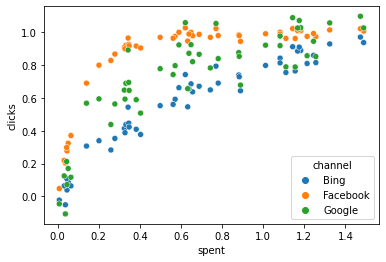

In [9]:
sns.scatterplot(x = "spent", y = "clicks", data = df, hue = "channel")

Data appears to follow the diminishing returns pattern

## Fit Exponential Model to Dataset

We proceed to fit a model per channel

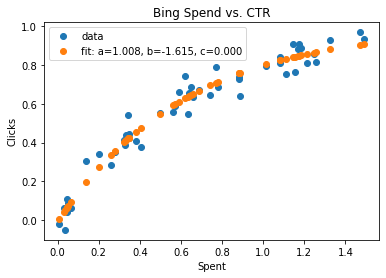

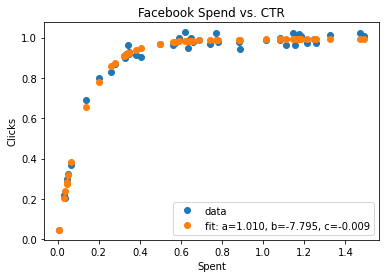

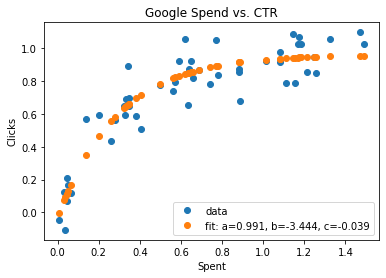

In [10]:
slope_dict = log_curve_fit(df)

In [11]:
#slope_dict stores the learned parameters of the exponential model of each channel
slope_dict

{'Bing': [1.0075280941715026, -1.6151686026611345, 9.999999999797504e-08],
 'Facebook': [1.0098511762232814, -7.795255487975849, -0.009291828619179954],
 'Google': [0.99121582324596, -3.4439137798358352, -0.03912380570034246]}

In [12]:
#study the residuals
df["function_value"] = df.apply(lambda row: get_function_value(row, slope_dict), axis=1)
df["residuals"] = df["clicks"] - df["function_value"]

In [13]:
df.head()

,spent,clicks,channel,function_value,residuals
0,0.201546,0.338910,Bing,0.272420,0.066490
1,0.382604,0.408662,Bing,0.456904,-0.048242
2,0.743153,0.648315,Bing,0.696635,-0.048319
3,1.183085,0.888836,Bing,0.850936,0.037899
4,0.140789,0.306389,Bing,0.197400,0.108989


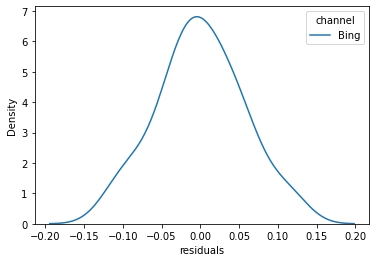

In [14]:
sns.kdeplot(data = df[df["channel"] == "Bing"], x = "residuals", hue = "channel")

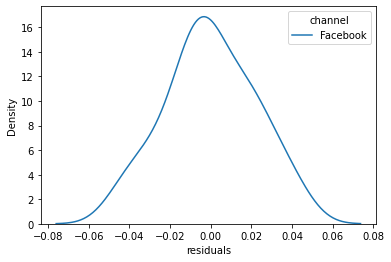

In [15]:
sns.kdeplot(data = df[df["channel"] == "Facebook"], x = "residuals", hue = "channel")

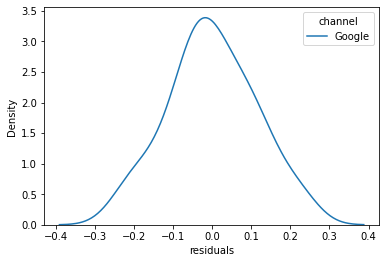

In [16]:
sns.kdeplot(data = df[df["channel"] == "Google"], x = "residuals", hue = "channel")

We observe that the residuals for each channel model appear to be fairly normally distributed

## Model Metric

In [17]:
df.head()

,spent,clicks,channel,function_value,residuals
0,0.201546,0.338910,Bing,0.272420,0.066490
1,0.382604,0.408662,Bing,0.456904,-0.048242
2,0.743153,0.648315,Bing,0.696635,-0.048319
3,1.183085,0.888836,Bing,0.850936,0.037899
4,0.140789,0.306389,Bing,0.197400,0.108989


In [18]:
def run_kfold(df_subset):
    
    X = df_subset["spent"]
    Y = df_subset["clicks"]
    pred_Y = df_subset["function_value"]
    
    kf = KFold(n_splits=5, shuffle = True, random_state = 44) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        predictions = pred_Y[test_index]
        accuracy = r2_score(Y_test, predictions)
        outcomes.append(accuracy)

    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean R2: {0}".format(mean_outcome)) 
    print("Standard Deviation R2: {0}".format(std_outcome)) 
    
    return Y_test, predictions

In [19]:
print("Bing Regression Model Fit Check")
df_temp = df[df["channel"] == "Bing"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold (df_temp)

Bing Regression Model Fit Check
Mean R2: 0.953096687063384
Standard Deviation R2: 0.02245187672913097


In [20]:
print("Facebook Regression Model Fit Check")
df_temp = df[df["channel"] == "Facebook"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold(df_temp)

Facebook Regression Model Fit Check
Mean R2: 0.9459224689646899
Standard Deviation R2: 0.06577241581771688


In [21]:
print("Google Regression Model Fit Check")
df_temp = df[df["channel"] == "Google"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold (df_temp)

Google Regression Model Fit Check
Mean R2: 0.817143509223165
Standard Deviation R2: 0.09311116657229392


The relatively low standard deviation of R2 across the folds suggests the models perform reliably across the dataset. Moreover, the mean R2 is acceptable for all 3 models/channels.

##Optimization

As per the marketing team, the expected customer lifetime value i.e. the value of each conversion is $1,000

In [22]:
#let's say this is the marketing monthly budget
budget = 5000

In [23]:
#baseline model - equal spend across channels. This is team's current spend methodology
equal_spend = budget * 1 / 3

print("Current spend for Bing is $", np.round(equal_spend,2))
print("Current spend for Facebook is $", np.round(equal_spend,2))
print("Current spend for Google is $", np.round(equal_spend,2))

Current spend for Bing is $ 1666.67
Current spend for Facebook is $ 1666.67
Current spend for Google is $ 1666.67


We note that the available data is actualy spend data transformed. The exponential model is built on transformed spend data. So when feeding values in exponential fuction, we use transformed spend data. 

In [24]:
#transformed budget
equal_spend_transformed = equal_spend / 10000

$Total Clicks = \sum_{channel}^\ CTR * Impressions$



In [25]:
#we use the above equation to get the total number of clicks for 1000 impressions
equal_spend_heuristic_clicks = 1000 * (function_value(slope_dict["Bing"], equal_spend_transformed) +
                       function_value(slope_dict["Facebook"], equal_spend_transformed) +
                       function_value(slope_dict["Google"], equal_spend_transformed)) 

print("Hence for every 1,000 impressions per channel, the expected number of clicks (using current methodology) is ", int(equal_spend_heuristic_clicks))

Hence for every 1,000 impressions per channel, the expected number of clicks (using current methodology) is  1348


In [26]:
#calculate optimum spend for budget of $5000
transformed_budget = 5000 / 10000

spend_dictionary = greedy_algo_optimal_values(slope_dict, transformed_budget)

print("Optimal spend for Bing is", np.round(spend_dictionary[1] * 10000,2))
print("Optimal spend for Facebook is", np.round(spend_dictionary[2]* 10000,2))
print("Optimal spend for Google is", np.round(spend_dictionary[3]* 10000,2))


Optimal spend for Bing is 400.0
Optimal spend for Facebook is 2200.0
Optimal spend for Google is 2400.0


In [27]:
#optimized model
optimized_clicks = 1000 * (function_value(slope_dict["Bing"], spend_dictionary[1]) +
                       function_value(slope_dict["Facebook"], spend_dictionary[2]) +
                       function_value(slope_dict["Google"], spend_dictionary[3])) 
print("Expected clicks from an ad campaign using optimized spending across channels is", int(optimized_clicks))

Expected clicks from an ad campaign using optimized spending across channels is 1391


In [28]:
click_lift = (optimized_clicks - equal_spend_heuristic_clicks)
print("The lift in the number of clicks is", int(click_lift))

The lift in the number of clicks is 43


As per previous analytics efforts, the estimated value of a click is quantified to be **$1,000**. This value was quantified simply as follows:

$Expected Click Value = P(conversion | click) * LTV$, where LTV is the lifetime value of a customer

In [29]:
print("Hence, the expected additional revenue from the lift in clicks is $", 1000*int(click_lift), "per each ad campaign")

Hence, the expected additional revenue from the lift in clicks is $ 43000 per each ad campaign
